<a href="https://colab.research.google.com/github/sbksum/RAG/blob/main/Semantic_Spotter_Shashi_Khurana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Submission by **Shashi Khurana**



**The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from various policy documents. We shall be using LLamaindex to build the generative search application.**



What is RAG ?

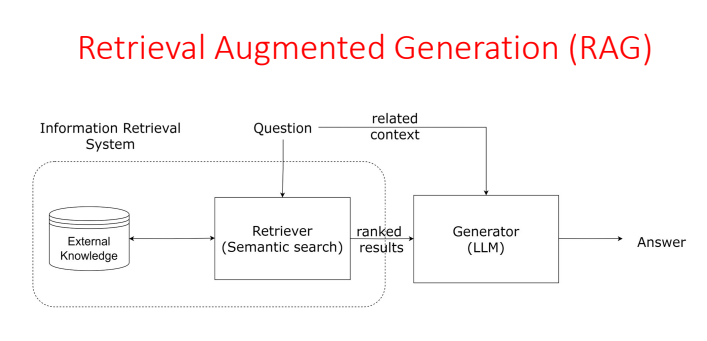

Without RAG: LLM's don't have any information on the domain/enterprise specific query.
With RAG: We are connecting an external data (ingested & transformed - embeddings - semantic search (dot product/cosine similarity) - top k relevant documents) - (context + user query)--> decorated using prompt engineering --> results

### Part 1 - Overall Product Specifications

***Problem Statement*** -  The goal of the project will be to build a robust generative search system capable of effectively and accurately answering questions from various policy documents. We shall be using LLamaindex to build the generative search application.


***Solution Strategy*** - Build a solution which should solve the following requirements:

- Users would responses from set of Insurance documents
- If they want to refer to the original document from which the bot is responding, the bot should provide a citation as well.

Goal - Solving the above two requirements well in the solution would ensure that the accuracy of the overall model is good and therefore further improvisations and customizations make sense.

***Data Used*** - 5 Policy documents stored in a single folder

***Tools used*** - LlamaIndex (only for now) has been used due to its powerful query engine, fast data processing using data loaders and directory readers as well as easier and faster implementation using fewer lines of code.

### Part 2 - Solution approach


In this section, we go ahead and actually build solution that we proposed in the previous step

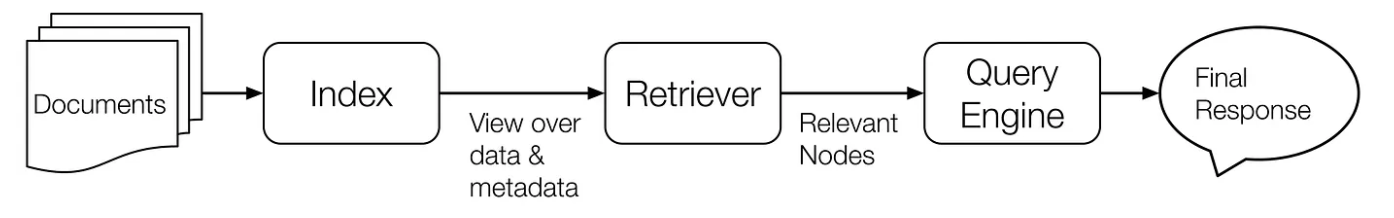

4 levels of LLM applications:
1. chatbot(LLM's internal memory) - openai, meta, google, microsoft, antrhopic, mistral, perplexity
2 chatbot with external memory(RAG) - llamindex, langchain,
3. Agents (LLM with tools) -langchain, llamaindex
4. LLM OS (LLM with tools, hardware(camera, mic, speaker,etc & an external memory) - Microsoft (memories)

Step 1 : Import the necessary libraries

In [9]:
#Load llamaindex
!pip install llama-index

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 40.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.8/146.8 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 6.1 MB/s eta 0:00:00


In [5]:
#Loading docx2txt for document reading related dependencies
!pip install docx2txt

  Preparing metadata (setup.py) ... done
  Created wheel for docx2txt: filename=docx2txt-0.8-py3-none-any.whl size=3960 sha256=39ce6c269fa1bfc59d6d4345a19be3a4c03f77243f05071a76f84d401f0f4d78
  Stored in directory: /root/.cache/pip/wheels/22/58/cf/093d0a6c3ecfdfc5f6ddd5524043b88e59a9a199cb02352966
Successfully built docx2txt


In [6]:
!pip install pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 4.9 MB/s eta 0:00:00


In [7]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.8/328.8 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.7 MB/s eta 0:00:00


In [10]:
from llama_index.llms.openai import OpenAI
from llama_index.core.llms import ChatMessage
import os
import openai

Step 2 : Mount your Google Drive and Set the API key

In [12]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
filepath = "/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/"
with open(filepath + "OPENAI_API_KEY.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

Step 3 - Data Loading


***2 ways to do this***

- If you have a single file containing all the required data, use a data loader from [LLamahub](https://llamahub.ai/)

- If you have multiple files, use *Simple Directory Reader* Just ensure that for reading each file type the necessary dependency libraries are already installed.

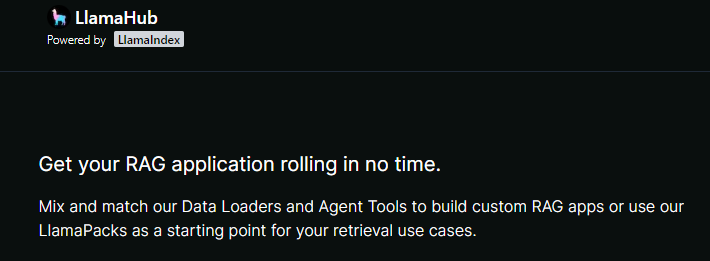

Recommendation - No matter how powerful the given data loader is, ensure that your file is properly formatted, and the loader is able to read the file clearly. Else the query engine might fail

In [14]:
os.chdir("/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/PolicyDocuments")
!ls

 HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
 HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
 HDFC-Life-Group-Term-Life-Policy.pdf
'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf'
 HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
 HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
 HDFC-Surgicare-Plan-101N043V01.pdf


In [15]:
from llama_index.core import SimpleDirectoryReader
reader = SimpleDirectoryReader(input_dir="/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/PolicyDocuments/")

In [16]:
?SimpleDirectoryReader

In [17]:
documents = reader.load_data()
print(f"Loaded {len(documents)} docs")

Loaded 217 docs


In [18]:
documents

[Document(id_='31f844fb-1cf6-4dee-81ed-24f30b0345e8', embedding=None, metadata={'page_label': '1', 'file_name': 'HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_path': '/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/PolicyDocuments/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_type': 'application/pdf', 'file_size': 1303156, 'creation_date': '2024-07-21', 'last_modified_date': '2023-09-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \n             Part A \n<<Date>> \n<<Policyholder’s Name>>  \n<<Policyholder’s Address>> \n<<Policyholder’s Contact Number>>  \n \nDear <<Policyholder’s Name>>,  \n \nSub: Your Policy no. <<  >> \nWe are glad to inform you that your proposal has been accepted and the H

In [19]:
documents[2]

Document(id_='2292e194-4788-4a59-aafb-4feccdd7f2b1', embedding=None, metadata={'page_label': '3', 'file_name': 'HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_path': '/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/PolicyDocuments/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf', 'file_type': 'application/pdf', 'file_size': 1303156, 'creation_date': '2024-07-21', 'last_modified_date': '2023-09-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=" \n POLICY DOCUMENT- HDFC LIFE EASY HEALTH  \n \nUnique Identification Number: <<101N110V03>> \n \n Your Policy is a Single Premium paying non participating non linked fixed benefit health plan. This document is \nthe evidence of a contract between HDFC Life Insurance Co

Step 4 - Building the query engine

In [20]:
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.core import VectorStoreIndex
from IPython.display import display, HTML

# create parser and parse document into nodes
parser = SimpleNodeParser.from_defaults()
nodes = parser.get_nodes_from_documents(documents)
# documents --> nodes

# # build index
index = VectorStoreIndex(documents)
#nodes --> index

# Construct Query Engine
query_engine = index.as_query_engine()

In [21]:
parser

SentenceSplitter(include_metadata=True, include_prev_next_rel=True, callback_manager=<llama_index.core.callbacks.base.CallbackManager object at 0x7b453338fee0>, id_func=<function default_id_func at 0x7b453aeb9090>, chunk_size=1024, chunk_overlap=200, separator=' ', paragraph_separator='\n\n\n', secondary_chunking_regex='[^,.;。？！]+[,.;。？！]?')

Step 5 - Checking response and response parameters

In [22]:
response = query_engine.query("What is this document talking about?")

In [23]:
#Checking the response
response.response

'This document is discussing the HDFC Life Sampoorna Jeevan policy.'

In [24]:
#Check the source node
response.source_nodes

[NodeWithScore(node=Document(id_='13c28e18-15ef-43f9-920c-9b65bcb7235a', embedding=None, metadata={'page_label': '41', 'file_name': 'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_path': '/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/PolicyDocuments/HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf', 'file_type': 'application/pdf', 'file_size': 1990500, 'creation_date': '2024-07-21', 'last_modified_date': '2023-09-29'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text=' \n  \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n \n', mimetype='text/plain', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: 

In [25]:
#Extract the file name
response.source_nodes[0].node.metadata['file_name']

'HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf'

In [26]:
#Extract the score
response.source_nodes[1].score

0.7888273766264634

Step 6 - Creating a response Pipeline

User receives the response and the document that they can refer to

In [27]:
## Query response function
def query_response(user_input):
  response = query_engine.query(user_input)
  file_name = response.source_nodes[0].node.metadata['file_name']
  final_response = response.response + '\n Check further at ' + file_name + ' document'
  return final_response

In [28]:
def initialize_conv():
  print('Feel free to ask Questions regarding Insurance Policy documents. Press exit once you are done')
  while True:
    user_input = input()
    if user_input.lower() == 'exit':
      print('Exiting the program... bye')
      break
    else:
      response = query_response(user_input)
      display(HTML(f'<p style="font-size:20px">{response}</p>'))

In [29]:
initialize_conv()

Feel free to ask Questions regarding Insurance Policy documents. Press exit once you are done
what is the eligibility criteria for Accidental Claims


how is premium for term life evaluated?


Is there any age criteria for availing term plan?


exit
Exiting the program... bye


Step 7 - Build a Testing Pipeline

Here we feed a series of questions to the Q/A bot and store the responses along with the feedback on whether it's accurate or not from the user

In [30]:
questions = ['What is this document all about?', "What are the various plans offered?",
             'What is the premium and eligibility criteria?',  'What documents need to produce for insurance policy?']

In [31]:
def testing_pipeline(questions):
  test_feedback  = []
  for i in questions:
    print(i)
    print(query_response(i))
    print('\n Please provide your feedback on the response provided by the bot')
    user_input = input()
    test_feedback.append((i,query_response(i),user_input))
  feedback_df = pd.DataFrame(test_feedback, columns =['Question', 'Response', 'Good or Bad'])
  return feedback_df

In [32]:
import pandas as pd

In [33]:
testing_pipeline(questions)

What is this document all about?
This document serves as the Master Policy for a Non-Linked Non-Participating Group Term Insurance Policy issued by HDFC Life Insurance Company Limited. It outlines the contractual agreement between the insurer and the Master Policyholder for the benefit of Scheme Members or their nominees, detailing the terms and conditions under which Benefits will be paid.
 Check further at HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf document

 Please provide your feedback on the response provided by the bot
Good
What are the various plans offered?
The various plans offered include Lump Sum Option, Income Option, Lump Sum with Income Option, and Income with Lump Sum Option. Each plan has different components such as Basic Sum Assured, Applicable Bonus, Applicable Terminal Bonus, Guaranteed Maturity Benefit, Guaranteed Income Benefit, and specific payout structures based on the chosen options.
 Check further at HDFC-Life-Smart-Pension-Plan-Policy-Doc

,Question,Response,Good or Bad
0,What is this document all about?,This document is the Master Policy Document fo...,Good
1,What are the various plans offered?,The various plans offered include Lump Sum Opt...,Good
2,What is the premium and eligibility criteria?,The premium must be paid promptly and regularl...,Good
3,What documents need to produce for insurance p...,"Completed claim form, Member Information/Enrol...",Good


In [34]:
from llama_index.core import PromptTemplate

text_qa_template_str = (
    "Context information is"
    " below.\n---------------------\n{context_str}\n---------------------\nUsing"
    " both the context information and also using your own knowledge, answer"
    " the question: {query_str}\nIf the context isn't helpful, you can also"
    " answer the question on your own.\n"
)
text_qa_template = PromptTemplate(text_qa_template_str)

refine_template_str = (
    "The original question is as follows: {query_str}\nWe have provided an"
    " existing answer: {existing_answer}\nWe have the opportunity to refine"
    " the existing answer (only if needed) with some more context"
    " below.\n------------\n{context_msg}\n------------\nUsing both the new"
    " context and your own knowledge, update or repeat the existing answer.\n"
)
refine_template = PromptTemplate(refine_template_str)

In [36]:
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader
from llama_index.llms.openai import OpenAI

llm = OpenAI(model="gpt-3.5-turbo")

documents = SimpleDirectoryReader("/content/drive/My Drive/Colab Notebooks/Semantic_Spotter/PolicyDocuments/").load_data()

index = VectorStoreIndex.from_documents(documents)

In [37]:
print(
    index.as_query_engine(
        text_qa_template=text_qa_template,
        refine_template=refine_template,
        llm=llm,
    ).query("how is the premium for term plan evaluated?")
)

The premium for a term plan is evaluated based on factors such as the sum assured, the age and gender of the insured, the term of the policy, the payment method, and the payment frequency. Additionally, policies with an initial sum assured greater than Rs 2,00,000 may be entitled to a discount of 35% on the excess of the actual premium over the premium corresponding to a sum assured of Rs 2,00,000. However, policies that are rated up are not eligible for this discount. The premium rate is guaranteed for a period of three years from the date of purchase, after which the premium rates may be reviewed every three years. Any changes in premium rates will be communicated to the policyholder and will be applicable from the next policy anniversary following the date of review.


### Part 3 - Next Steps/ Overall Recommendations



- Based on the testing pipeline's feedback develop a strategy on how to improve this further
  - This can be through building a better/cleaner dataset, or utilizing better data pre-processing techniques
- Few suggestions based on the common tools that we have in the pipeline